## Working with DateTime fields

In [2]:
library(plyr)
library(ggplot2)
library(tidyverse)
library(lubridate)
library(tibble)
library(chron)
library(ISLR)
library(tree)
library(rsample)  # data splitting 
library(dplyr)    # data transformation
library(ggplot2)  # data visualization
library(caret)    # implementing with caret
library(h2o)      # implementing with h2o
library(klaR)

#options(stringsAsFactors = FALSE)

In [3]:
CrimeData = read.csv("NYPD_Complaint_Data_Current__Year_To_Date_.csv")

In [19]:
CD <- data.frame(CrimeData[1:300000,])

CD$ADDR_PCT_CD  <- as.factor(CD$ADDR_PCT_CD)
CD$ReportedDate <- mdy(CD$CMPLNT_TO_DT)

CD$ReportedDate <- as.Date(CD$ReportedDate)

CD$ReportedTime <- CD$CMPLNT_FR_TM
CD$ReportedTime <- chron(times=CD$ReportedTime)

CD$CMPLNT_FR_DT <- NULL
CD$CMPLNT_TO_DT <- NULL

In [20]:
CrimesAgainstBusiness    <- CD[CD$VIC_SEX == 'D',]
CrimesAgainstPeopleOfNYS <- CD[CD$VIC_SEX == 'E',]
CrimesAgainstPersons     <- CD[CD$VIC_SEX == 'M' | CD$VIC_SEX == 'F',]

## Temporary T Dataset for Pre-Processing and Visualization

In [33]:
T <- data.frame(
    Precinct        = CrimesAgainstPersons$ADDR_PCT_CD,
    OffenseDesc     = CrimesAgainstPersons$OFNS_DESC,
    VicSex          = CrimesAgainstPersons$VIC_SEX,
    VicRace         = CrimesAgainstPersons$VIC_RACE,
    VicAgeGroup     = CrimesAgainstPersons$VIC_AGE_GROUP,
    ReportedDate    = CrimesAgainstPersons$ReportedDate,
    ReportedTime    = CrimesAgainstPersons$ReportedTime,
    Borough         = CrimesAgainstPersons$BORO_NM,
    PremisesType    = CrimesAgainstPersons$PREM_TYP_DESC,
    SusAgeGroup     = CrimesAgainstPersons$SUSP_AGE_GROUP,
    SusRace         = CrimesAgainstPersons$SUSP_RACE,
    SusSex          = CrimesAgainstPersons$SUSP_SEX,
    Latitude        = CrimesAgainstPersons$Latitude,
    Longitude       = CrimesAgainstPersons$Longitude
)

VIC_BizOrg         = ifelse(T$VicSex == "D", 1,0)
VIC_PPLOfNYS       = ifelse(T$VicSex == "E", 1,0)

# Convert Column Types
T$OffenseDesc <- as.factor(T$OffenseDesc)
T$ReportedDate <- as.POSIXlt(T$ReportedDate)

T <- na.omit(T)

# Remove all records older than 2020-01-01
T <- subset(T, T$ReportedDate > ("2019-12-31"))

# Add month column

T$Month = rep(0, nrow(T))

T$Month <- as.POSIXlt(T$ReportedDate)
T$Month <- format(as.Date(T$Month), "%B")

T <- na.omit(T)
T <- T[order(as.Date(T$ReportedDate)),]

# Adding a Week column
T$Week = rep(0, nrow(T))
T$Week <- strftime(T$ReportedDate, format = "%V")

# Adding a  Day Of Week column
T$DayOfWeek = rep(0, nrow(T))
T$DayOfWeek <- strftime(T$ReportedDate, format = "%A")

# Add an hour column
T$ReportedTime <- as.factor(T$ReportedTime)

T$Hour = rep(0, nrow(T))
T$Hour <- format(as.POSIXct(T$ReportedTime,format="%H:%M:%S"),"%H")

T <- na.omit(T)

### NYPD - Processing Ready Dataset

In [34]:
# Create Final Processing Ready Dataset

NYPD <- T

NYPD <- na.omit(NYPD)

NYPD$PremisesType      <- as.factor(NYPD$PremisesType)
NYPD$Borough           <- as.factor(NYPD$Borough)

# Cleaning dataset
NYPD <- na.omit(NYPD)

## Cleaning location data
NYPD <- subset(NYPD, 
               Borough == "BROOKLYN" |
               Borough == "BRONX"|
               Borough == "QUEENS" |
               Borough == "STATEN ISLAND" |
               Borough == "MANHATTAN"
              )

NYPD$Borough <- droplevels(NYPD$Borough)

NYPD <- subset(NYPD,
               PremisesType == "RESIDENCE - APT. HOUSE" |
               PremisesType == "STREET" |
               PremisesType == "RESIDENCE-HOUSE" |
               PremisesType == "RESIDENCE - PUBLIC HOUSING" |
               PremisesType == "OTHER" |
               PremisesType == "GROCERY/BODEGA" |
               PremisesType == "COMMERCIAL BUILDING" |
               PremisesType == "PARK/PLAYGROUND" |
               PremisesType == "RESTAURANT/DINER"|
               PremisesType == "HOTEL/MOTEL" |
               PremisesType == "CHAIN STORE" |
               PremisesType == "HOMELESS SHELTER" |
               PremisesType == "PARKING LOT/GARAGE (PUBLIC" |
               PremisesType == "FAST FOOD" |
               PremisesType == "HOSPITAL" |
               PremisesType == "PARKING LOT/GARAGE (PRIVATE)" |
               PremisesType == "BAR/NIGHT CLUB" |
               PremisesType == "DEPARTMENT STORE" |
               PremisesType == "PUBLIC SCHOOL" |
               PremisesType == "BANK" |
               PremisesType == "BUS (NYC TRANSIT)" |
               PremisesType == "PUBLIC BUILDING" |
               PremisesType == "FOOD SUPERMARKET" |
               PremisesType == "DRUG STORE" |
               PremisesType == "HIGHWAY/PARKWAY" |
               PremisesType == "GAS STATION" |
               PremisesType == "DRY CLEANER/LAUNDRY" |
               PremisesType == "DOCTOR/DENTIST OFFICE"               
              )

NYPD$PremisesType <- droplevels(NYPD$PremisesType)

## CLEANING VICTIM DATA
NYPD <- subset(NYPD, 
               VicAgeGroup == "<18" |
               VicAgeGroup == "18-24" |
               VicAgeGroup == "25-44" |
               VicAgeGroup == "45-64" |
               VicAgeGroup == "65+" |
               VicAgeGroup == "UNKNOWN"
              )

NYPD$VicAgeGroup <- droplevels(NYPD$VicAgeGroup)

NYPD <- subset(NYPD, VicSex == "M" | VicSex == "F")
NYPD$VicSex <-droplevels(NYPD$VicSex)

NYPD <- subset(NYPD,
               VicRace == "AMERICAN INDIAN/ALASKAN NATIVE" |
               VicRace == "ASIAN / PACIFIC ISLANDER" |
               VicRace == "BLACK" |
               VicRace == "BLACK HISPANIC" |
               VicRace == "WHITE HISPANIC" |
               VicRace == "WHITE" |
               VicRace == "UNKNOWN"
              )

NYPD$VicRace <- droplevels(NYPD$VicRace)

## CLEANING SUSPECT DATA
NYPD <- subset(NYPD, 
               Borough == "BROOKLYN" |
               Borough == "BRONX"|
               Borough == "QUEENS" |
               Borough == "STATEN ISLAND" |
               Borough == "MANHATTAN"
              )

NYPD$Borough <- droplevels(NYPD$Borough)

## CLEANING SUSPECT DATA
NYPD <- subset(NYPD, 
               SusAgeGroup == "<18" |
               SusAgeGroup == "18-24" |
               SusAgeGroup == "25-44" |
               SusAgeGroup == "45-64" |
               SusAgeGroup == "65+"   |
               SusAgeGroup == "UNKNOWN"
              )

NYPD$SusAgeGroup <- droplevels(NYPD$SusAgeGroup)

NYPD <- subset(NYPD, SusSex == "M" | SusSex == "F")
NYPD$SusSex <-droplevels(NYPD$SusSex)

NYPD <- subset(NYPD,
               SusRace == "AMERICAN INDIAN/ALASKAN NATIVE" |
               SusRace == "ASIAN / PACIFIC ISLANDER" |
               SusRace == "BLACK" |
               SusRace == "BLACK HISPANIC" |
               SusRace == "WHITE HISPANIC" |
               SusRace == "WHITE" |
               SusRace == "UNKNOWN"
              )
NYPD$SusRace <- droplevels(NYPD$SusRace)


NYPD <- subset(NYPD, 
               OffenseDesc == "HARRASSMENT 2" |
               #OffenseDesc == "FELONY ASSAULT"|
               OffenseDesc == "CRIMINAL MISCHIEF & RELATED OF"|
               OffenseDesc == "GRAND LARCENY"|
               OffenseDesc == "OFF. AGNST PUB ORD SENSBLTY &"|
               OffenseDesc == "ROBBERY"|
               OffenseDesc == "VEHICLE AND TRAFFIC LAWS"|
               OffenseDesc == "SEX CRIMES"|
               OffenseDesc == "OFFENSES AGAINST PUBLIC ADMINI"|
               OffenseDesc == "THEFT-FRAUD"|
               OffenseDesc == "RAPE"|
               OffenseDesc == "CRIMINAL TRESPASS"|
               OffenseDesc == "FRAUDS"|
               OffenseDesc == "UNAUTHORIZED USE OF A VEHICLE"|
               OffenseDesc == "ADMINISTRATIVE CODE"
              )

NYPD$Hour       <- as.numeric(NYPD$Hour)
NYPD$Month      <- as.factor(NYPD$Month)
NYPD$Week       <- as.numeric(NYPD$Week)
NYPD$DayOfWeek  <- as.factor(NYPD$DayOfWeek)
NYPD$Precinct   <- as.factor(NYPD$Precinct)

NYPD$Harrassment   = ifelse(NYPD$OffenseDesc == "HARRASSMENT 2", "YES", "NO")
NYPD$Harrassment <- as.factor(NYPD$Harrassment)

NYPD$OffenseDesc <- droplevels(NYPD$OffenseDesc)

NYPD           <- as.data.frame(NYPD)
rownames(NYPD) <- NULL


NYPD$ReportedDate <- NULL
NYPD$ReportedTime <- NULL
NYPD$OffenseDesc  <- NULL
#NYPD$Latitude     <- NULL
#NYPD$Longitude    <- NULL
#NYPD$Week         <- NULL
#NYPD$Hour         <- NULL



# Cleaning dataset
NYPD <- na.omit(NYPD)


## Creating Training and Validation Datasets

In [35]:
## 75% of the sample size
smp_size <- floor(0.75 * nrow(NYPD))

## set the seed to make your partition reproducible
set.seed(123)
train_ind <- sample(seq_len(nrow(NYPD)), size = smp_size, replace = TRUE)

train <- NYPD[train_ind, ]
test  <- NYPD[-train_ind, ]

rownames(train) <- NULL
rownames(test) <- NULL

dim(train)
dim(test)

[1] 47482    16

[1] 29976    16

## Naive Bayes Classifier

In [36]:
summary(NYPD)
rbind(sapply(NYPD, class))
#sapply(test, class)

    Precinct     VicSex                              VicRace     
 75     : 2120   F:39267   AMERICAN INDIAN/ALASKAN NATIVE:  278  
 40     : 1782   M:24043   ASIAN / PACIFIC ISLANDER      : 5603  
 47     : 1515             BLACK                         :23823  
 48     : 1514             BLACK HISPANIC                : 3570  
 46     : 1464             UNKNOWN                       : 2506  
 114    : 1419             WHITE                         :11692  
 (Other):53496             WHITE HISPANIC                :15838  
  VicAgeGroup             Borough                          PremisesType  
 <18    : 3255   BRONX        :13588   RESIDENCE - APT. HOUSE    :22142  
 18-24  : 7711   BROOKLYN     :19186   STREET                    :13745  
 25-44  :31293   MANHATTAN    :12693   RESIDENCE-HOUSE           :10817  
 45-64  :16719   QUEENS       :15001   RESIDENCE - PUBLIC HOUSING: 7785  
 65+    : 3611   STATEN ISLAND: 2842   OTHER                     : 1374  
 UNKNOWN:  721              

Precinct VicSex VicRace VicAgeGroup Borough PremisesType SusAgeGroup
[1,] factor   factor factor  factor      factor  factor       factor     
     SusRace SusSex Latitude Longitude Month  Week    DayOfWeek Hour   
[1,] factor  factor numeric  numeric   factor numeric factor    numeric
     Harrassment
[1,] factor

In [37]:
#VicSex, VicRace, VicAgeGroup, Borough, PremisesType, SusAgeGroup, SusRace, SusSex, Latitude, Longitude, Month, Week, DayOfWeek,Hour, Harrassment

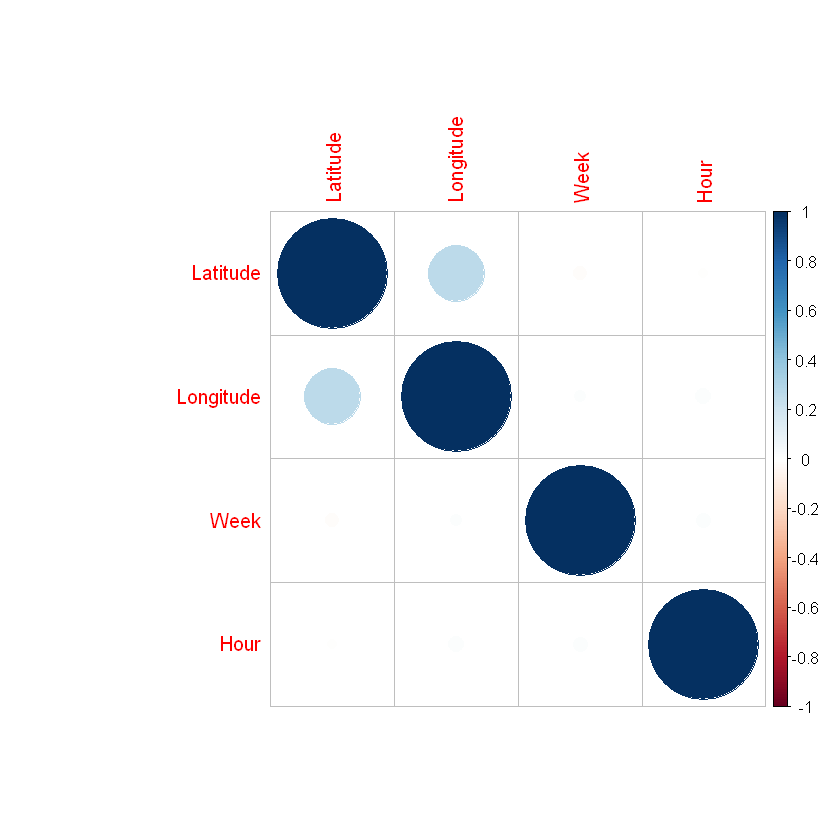

In [38]:
train %>%
  filter(Harrassment == "YES") %>%
  select_if(is.numeric) %>%
  cor() %>%
  corrplot::corrplot()

In [39]:
train$Latitude  <- NULL
train$Longitude <- NULL
train$Week      <- NULL
train$Hour      <- NULL

#sapply(train, class)

Warning message:
"attributes are not identical across measure variables;
they will be dropped"


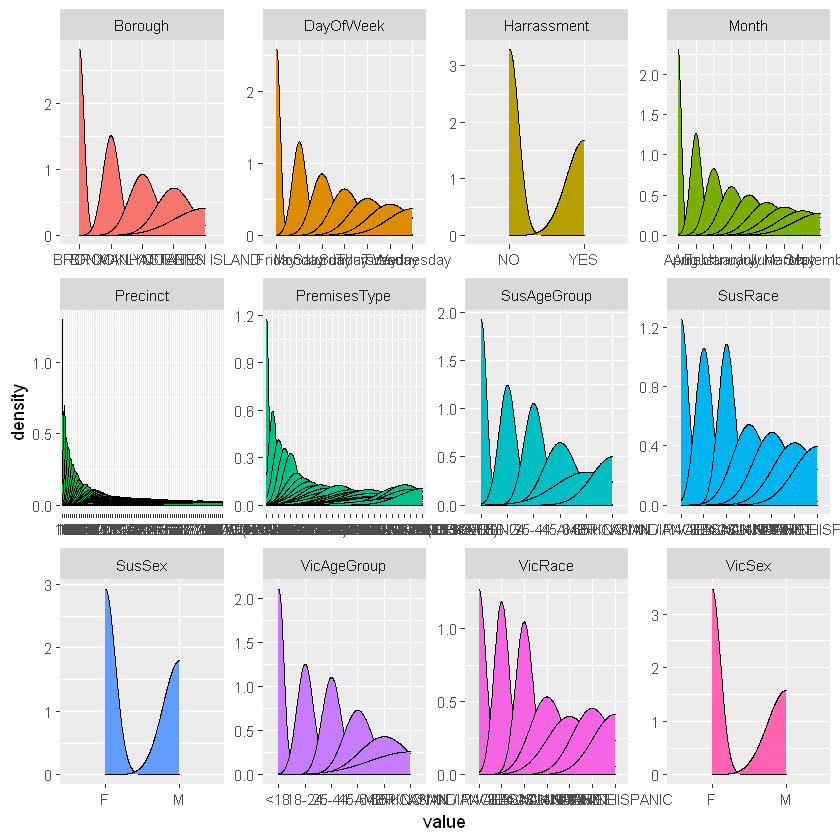

In [40]:
train %>% 
  #select(VicSex, VicRace, VicAgeGroup, Borough, PremisesType, SusAgeGroup, SusRace, SusSex, Month, DayOfWeek, Harrassment) %>% 
  gather(metric, value) %>% 
  ggplot(aes(value, fill = metric)) + 
  geom_density(show.legend = FALSE) + 
  facet_wrap(~ metric, scales = "free")

In [41]:
# create response and feature data
features <- setdiff(names(train), "Harrassment")
x <- train[, features]
y <- train$Harrassment

In [42]:
# set up 10-fold cross validation procedure
train_control <- trainControl(
  method = "cv", 
  number = 10
  )

In [43]:
# train model
nb.m1 <- train(
  x = x,
  y = y,
  method = "nb",
  trControl = train_control
  )

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"
Warning message

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 158"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 161"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 164"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 166"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 168"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 169"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 171"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 299"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 308"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 431"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 433"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 436"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 570"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 573"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 578"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 724"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 871"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 872"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 984"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 990"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1005"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1125"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1278"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1282"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1283"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1286"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1537"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1543"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1820"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1821"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1824"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1825"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1832"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1962"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1963"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1966"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1968"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1971"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1974"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2097"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2098"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2099"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2100"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2102"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2104"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2106"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2220"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2221"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2223"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2224"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2229"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2231"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2232"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2352"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2355"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2356"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2358"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2492"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2628"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2630"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2631"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2633"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2634"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2635"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2636"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2760"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2762"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2764"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2765"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2768"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2771"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2774"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3038"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3040"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3041"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3159"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3165"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3166"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3167"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3168"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3171"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3172"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3173"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3464"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3600"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3601"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3859"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4272"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4278"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4281"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4416"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4420"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4552"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4664"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4667"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4668"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4669"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4670"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4672"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 59"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 60"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 61"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 62"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 66"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 67"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 68"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 71"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 74"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 217"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 339"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 351"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 352"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 473"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 475"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 480"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 483"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 488"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 490"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 609"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 620"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 622"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 623"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 624"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 626"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 629"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 630"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 763"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 766"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 768"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 770"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 771"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 781"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 782"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 902"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 907"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 917"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1037"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1038"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1040"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1042"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1329"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1446"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1454"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1732"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1873"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2011"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2015"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2016"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2017"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2272"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2276"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2393"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2394"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2404"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2543"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2821"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2824"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2825"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2833"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2835"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2952"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2953"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2954"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2959"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2965"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2968"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3089"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3092"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3218"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3221"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3361"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3366"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3372"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3373"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3500"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3504"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3643"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3655"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3772"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3777"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3785"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3906"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4032"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4034"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4036"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4332"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4467"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4709"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 92"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 94"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 97"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 98"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 99"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 100"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 101"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 102"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 103"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 104"
Warni

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 220"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 221"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 222"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 223"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 339"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 352"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 353"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 488"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 490"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 491"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 496"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 500"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 501"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 619"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 620"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 621"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 625"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 626"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 627"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 628"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 630"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 632"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 633"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 752"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 753"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 754"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 755"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 758"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 759"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 761"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 762"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 763"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 764"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 898"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 900"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 903"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 905"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 918"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1165"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1166"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1167"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1171"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1172"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1173"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1175"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1302"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1437"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1440"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1564"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1697"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1827"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1832"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1835"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1976"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1978"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2120"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2121"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2126"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2278"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2283"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2429"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2431"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2560"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2812"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2815"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2818"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2819"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2820"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2821"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2953"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2959"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2960"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2961"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2964"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2965"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2966"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3087"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3089"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3090"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3091"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3092"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3095"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3096"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3223"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3224"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3225"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3229"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3231"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3233"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3234"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3355"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3356"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3358"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3361"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3362"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3366"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3367"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3480"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3483"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3490"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3492"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3609"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3616"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3618"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3739"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3742"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3743"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3744"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3745"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3747"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3751"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3873"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3877"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3888"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4006"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4007"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4011"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4015"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4264"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4419"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4552"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4672"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 57"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 59"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 60"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 68"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 69"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 73"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 74"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 75"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 76"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 178"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 192"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 309"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 310"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 315"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 318"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 454"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 466"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 467"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 471"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 600"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 733"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 871"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 873"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 876"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1006"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1007"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1010"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1015"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1019"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1136"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1251"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1252"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1258"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1531"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1534"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1658"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1661"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1800"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1930"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1931"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1934"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1943"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2087"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2090"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2092"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2094"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2096"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2097"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2098"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2230"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2233"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2236"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2238"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2239"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2243"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2244"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2245"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2389"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2390"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2391"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2394"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2521"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2524"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2526"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2527"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2528"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2531"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2533"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2657"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2658"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2659"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2661"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2665"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2667"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2793"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2924"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2928"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2930"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3055"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3056"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3063"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3065"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3068"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3196"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3198"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3200"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3329"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3454"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3579"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3709"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3841"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3842"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3847"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3848"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3849"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3974"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3976"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3977"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3988"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4106"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4113"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4116"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4236"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4239"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4242"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4244"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4245"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4380"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4381"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4382"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4383"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4386"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4501"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4643"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 31"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 32"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 33"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 35"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 40"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 41"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 43"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 158"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 166"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 167"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 171"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 172"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 174"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 307"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 431"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 433"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 438"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 560"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 564"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 687"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 827"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 828"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 832"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 833"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 840"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 956"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 964"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 968"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 969"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 973"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1087"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1089"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1091"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1093"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1096"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1099"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1100"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1232"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1234"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1236"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1238"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1239"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1243"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1362"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1363"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1364"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1366"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1368"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1516"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1770"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1772"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1774"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1922"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2033"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2034"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2035"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2037"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2041"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2042"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2177"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2178"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2464"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2467"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2845"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2847"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2848"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2849"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2850"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2852"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2854"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2968"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2969"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2976"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3098"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3099"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3102"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3103"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3104"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3105"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3233"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3234"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3238"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3243"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3246"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3247"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3364"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3366"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3502"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3503"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3504"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3635"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3643"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3763"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3765"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3766"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3767"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3769"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3770"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3772"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3775"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3777"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4061"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4063"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4067"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4068"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4071"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4073"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4200"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4332"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4464"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4473"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4740"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 124"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 125"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 126"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 130"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 243"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 245"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 246"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 250"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 251"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 252"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 259"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 380"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 382"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 383"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 384"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 385"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 386"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 520"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 521"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 522"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 648"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 785"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 786"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 790"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 793"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 795"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 922"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 927"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1177"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1464"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1469"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1600"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1601"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1989"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2131"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2135"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2278"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2404"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2420"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2552"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2802"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2809"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2817"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2818"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2924"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2925"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3056"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3059"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3061"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3196"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3329"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3466"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3601"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3856"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4011"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4019"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4155"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4159"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4281"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4283"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4286"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4416"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4420"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 63"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 64"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 65"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 67"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 68"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 69"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 70"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 77"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 78"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 219"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 351"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 352"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 480"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 486"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 600"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 724"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 841"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 842"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 847"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 850"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 855"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 988"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1000"

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1149"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1272"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1276"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1281"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1697"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1833"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1844"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1989"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2120"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2121"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2124"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2250"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2252"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2522"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2523"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2524"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2525"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2528"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2529"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2657"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2658"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2662"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2663"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2664"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2665"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2667"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2800"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2802"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2922"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2925"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3055"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3056"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3062"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3309"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3315"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3440"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3579"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3704"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3847"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3848"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3849"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3852"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3984"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3989"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4113"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4116"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4248"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4251"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4258"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4260"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4387"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4390"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4391"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4393"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4394"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4404"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4527"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4529"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4531"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4533"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4667"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4668"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4670"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 54"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 55"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 57"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 58"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 60"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 61"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 62"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 63"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 64"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 65"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 196"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 200"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 203"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 332"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 341"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 454"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 472"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 579"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 592"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 699"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 710"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 713"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 832"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 833"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 841"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 842"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 974"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 988"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1135"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1264"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1388"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1392"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1393"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1533"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1534"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1820"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1823"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1825"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1827"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1828"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1969"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1971"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2116"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2236"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2238"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2242"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2244"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2245"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2250"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2384"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2385"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2386"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2388"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2389"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2392"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2393"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2516"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2522"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2657"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2658"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2786"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2795"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2906"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3037"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3038"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3041"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3174"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3175"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3178"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3302"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3437"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3440"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3570"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3571"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3573"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3704"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3833"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3839"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3842"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3968"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3974"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3976"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3978"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4095"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4097"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4098"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4099"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4102"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4104"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4105"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4236"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4246"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4248"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4381"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4383"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4384"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4387"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4390"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4516"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4526"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4527"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4529"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4655"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4657"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4659"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4663"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4664"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4667"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4668"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 46"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 47"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 48"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 52"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 53"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 54"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 55"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 57"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 58"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 61"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 198"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 200"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 204"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 346"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 475"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 488"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 616"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 617"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 618"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 739"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 740"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 741"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 859"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 871"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1006"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1011"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1276"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1281"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1665"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1667"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1668"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1669"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1802"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1809"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1928"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1930"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1933"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1934"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1935"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1938"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1940"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2077"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2086"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2227"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2230"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2231"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2233"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2234"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2239"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2361"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2363"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2364"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2367"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2500"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2503"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2629"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2630"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2633"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2634"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2635"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2636"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2760"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2765"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2766"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2768"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2769"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2770"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2771"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2772"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2773"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2903"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2904"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2906"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2907"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3034"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3038"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3041"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3042"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3173"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3174"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3177"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3315"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3437"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3710"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3856"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4131"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4136"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4278"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4281"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4282"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4286"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4531"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4659"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4664"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4665"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4670"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 54"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 55"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 57"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 58"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 61"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 62"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 63"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 65"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 67"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 68"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 200"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 213"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 351"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 488"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 490"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 492"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 494"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 498"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 616"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 617"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 618"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 619"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 620"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 621"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 623"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 624"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 739"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 740"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 741"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 742"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 743"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 744"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 745"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 749"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 871"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 873"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 877"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 879"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1006"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1011"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1016"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1017"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1019"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1158"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1159"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1161"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1281"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1416"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1419"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1809"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1812"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1815"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1816"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1817"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1935"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1938"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1940"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1942"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1947"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1956"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2086"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2090"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2091"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2098"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2099"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2101"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2234"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2239"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2244"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2245"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2246"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2247"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2384"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2385"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2387"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2388"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2389"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2636"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2643"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2770"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2771"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2772"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2773"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2774"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2775"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3056"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3196"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3871"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4010"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4149"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4286"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4296"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4419"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4670"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 58"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 59"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 60"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 65"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 66"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 68"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 70"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 73"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 77"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 218"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 220"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 222"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 224"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 225"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 229"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 230"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 353"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 356"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 358"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 362"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 366"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 494"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 495"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 496"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 503"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 513"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 627"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 633"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 634"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 636"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 648"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 785"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 793"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 922"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1059"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1062"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1198"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1329"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1332"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1480"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1483"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1607"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1859"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2258"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2260"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2394"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2531"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2534"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2543"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2672"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2793"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2795"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2936"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2938"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2941"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2943"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2949"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3086"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3087"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3353"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3355"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3488"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3490"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3491"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3607"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3745"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3747"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3748"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3749"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3751"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3752"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3753"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3754"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3756"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3883"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3886"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3887"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3890"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3894"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4026"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4028"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4029"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4282"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4429"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4570"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 58"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 59"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 60"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 65"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 66"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 68"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 70"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 73"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 77"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 218"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 220"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 222"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 224"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 225"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 229"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 230"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 353"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 356"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 358"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 362"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 366"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 494"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 495"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 496"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 503"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 513"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 627"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 633"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 634"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 636"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 648"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 785"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 793"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 922"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1059"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1062"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1198"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1329"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1332"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1480"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1483"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1607"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1859"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2258"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2260"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2394"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2531"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2534"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2543"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2672"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2793"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2795"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2936"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2938"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2941"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2943"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2949"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3086"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3087"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3353"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3355"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3488"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3490"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3491"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3607"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3745"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3747"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3748"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3749"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3751"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3752"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3753"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3754"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3756"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3883"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3886"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3887"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3890"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3894"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4026"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4028"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4029"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4282"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4429"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4570"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 66"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 69"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 70"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 71"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 73"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 74"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 75"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 76"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 77"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 206"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 339"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 350"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 473"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 485"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 600"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 607"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 609"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 612"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 732"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 735"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 876"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 877"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 886"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1024"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1027"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1028"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1029"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1030"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1033"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1164"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1166"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1167"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1171"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1173"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1174"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1296"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1299"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1302"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1432"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1812"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1814"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1815"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1816"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1947"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1950"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1952"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1954"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1957"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2072"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2076"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2089"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2222"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2223"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2229"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2231"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2504"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2781"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2796"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2924"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2929"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2931"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2933"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2934"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3061"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3062"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3063"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3064"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3065"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3067"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3175"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3888"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4015"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4016"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4017"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4019"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4024"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4286"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4560"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 66"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 69"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 70"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 71"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 73"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 74"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 75"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 76"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 77"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 206"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 339"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 350"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 473"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 485"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 600"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 607"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 609"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 612"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 732"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 735"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 876"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 877"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 886"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1024"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1027"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1028"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1029"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1030"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1033"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1164"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1166"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1167"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1171"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1173"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1174"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1296"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1299"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1302"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1432"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1812"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1814"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1815"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1816"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1947"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1950"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1952"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1954"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1957"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2072"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2076"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2089"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2222"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2223"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2229"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2231"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2504"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2781"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2796"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2924"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2929"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2931"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2933"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2934"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3061"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3062"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3063"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3064"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3065"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3067"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3175"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3888"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4015"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4016"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4017"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4019"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4024"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4286"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4560"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 72"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 73"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 75"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 77"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 78"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 80"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 81"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 82"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 85"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 86"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 220"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 221"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 353"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 358"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 365"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 492"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 496"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 500"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 502"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 503"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 506"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 655"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 781"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 785"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 786"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 789"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 922"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 924"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1055"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1059"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1062"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1064"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1065"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1066"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1068"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1474"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1475"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1476"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1480"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1619"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1621"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1622"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1625"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1626"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1628"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1629"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1630"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1759"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1760"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1761"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1765"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1769"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1770"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1773"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2055"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2315"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2466"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2469"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2609"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2616"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2618"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2619"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2732"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2857"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2989"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3126"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3136"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3258"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3262"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3368"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3520"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3521"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3655"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3657"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3661"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3796"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3938"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3943"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3947"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3954"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4073"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4075"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4076"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4222"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4223"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4351"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4476"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4482"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4483"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4617"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4621"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4622"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4624"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4628"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 158"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 159"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 161"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 164"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 296"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 299"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 429"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 440"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 442"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 579"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 593"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 730"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 849"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 852"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 854"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 859"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 869"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1155"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1162"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1419"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1431"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1432"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1564"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1856"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1863"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2005"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2120"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2121"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2124"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2125"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2258"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2262"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2416"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2795"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2796"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2800"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2802"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2939"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2940"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2941"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2949"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2950"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3071"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3072"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3073"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3075"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3076"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3077"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3198"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3315"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3454"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3466"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3601"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3740"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3742"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3744"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3745"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3746"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3747"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3748"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3883"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3886"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3887"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3888"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3889"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4026"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4030"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4031"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4032"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4033"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4035"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4036"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4037"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4040"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4155"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4158"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4164"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4287"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4302"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4419"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4420"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4699"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4703"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4704"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 102"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 103"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 104"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 114"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 231"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 232"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 238"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 239"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 243"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 244"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 373"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 380"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 386"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 388"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 391"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 516"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 520"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 521"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 655"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 661"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 664"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 667"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 786"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 790"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 793"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 796"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 928"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 929"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 933"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 934"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 935"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 939"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 940"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 941"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1059"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1061"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1062"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1064"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1065"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1066"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1068"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1466"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1469"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1474"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1475"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1476"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1610"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1741"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1742"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1743"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1744"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1746"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1748"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1750"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1751"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1753"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1873"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1876"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1883"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2007"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2011"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2017"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2135"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2136"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2260"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2393"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2533"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2537"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2655"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2657"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2661"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2662"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2665"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2793"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3709"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3838"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3839"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3841"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3845"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3850"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3852"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3969"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3971"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3974"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3977"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3978"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4113"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4116"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4252"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4262"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4264"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4381"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4382"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4386"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4387"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4389"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4390"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4501"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4502"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4626"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4627"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4632"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 30"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 32"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 33"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 34"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 36"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 38"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 41"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 174"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 177"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 178"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 187"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 315"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 319"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 449"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 464"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 586"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 598"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 739"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 740"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 876"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 877"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 880"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1007"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1010"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1126"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1131"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1135"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1277"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1278"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1282"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1416"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1533"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1537"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1665"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1667"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1812"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1814"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1815"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1816"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1817"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1818"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1820"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1938"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1940"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1942"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2072"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2073"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2075"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2076"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2077"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2351"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2466"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2469"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2473"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2474"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2600"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2601"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2722"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2728"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2729"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2850"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2852"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2854"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2857"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2858"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2976"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2977"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2978"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2990"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3116"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3120"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3124"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3126"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3258"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3260"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3262"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3382"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3383"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3384"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3387"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3390"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3391"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3392"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3393"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3521"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3522"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3523"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3525"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3527"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3528"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3529"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3655"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3657"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3658"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3777"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3786"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3790"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3904"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4040"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4041"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4042"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4198"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4446"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4449"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4570"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4573"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 105"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 106"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 113"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 115"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 225"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 227"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 228"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 229"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 232"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 241"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 361"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 363"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 366"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 368"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 372"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 375"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 496"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 502"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 511"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 631"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 632"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 634"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 649"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 767"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 768"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 769"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 770"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 771"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 773"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 774"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 775"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 777"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 925"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1037"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1038"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1040"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1041"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1171"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1173"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1174"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1175"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1177"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1178"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1299"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1429"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1431"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1433"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1437"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1670"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1672"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1802"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1809"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1950"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1952"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1953"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1957"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1959"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1960"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2071"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2075"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2077"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2346"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2347"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2350"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2351"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2473"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2475"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2476"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2600"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2605"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2732"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2739"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2883"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2886"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2887"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2889"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3005"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3007"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3131"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3136"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3276"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3283"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3286"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3428"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3432"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3564"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3824"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3827"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3828"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3835"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3838"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3953"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3956"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3957"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3959"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3963"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3965"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4095"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4098"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4099"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4100"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4103"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4104"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4224"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4225"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4226"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4227"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4231"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4232"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4233"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4236"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4362"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4364"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4366"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4373"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4516"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4641"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4643"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4647"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 36"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 40"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 41"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 42"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 44"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 45"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 46"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 47"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 49"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 50"
Warning me

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 166"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 169"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 177"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 187"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 309"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 313"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 319"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 432"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 433"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 440"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 447"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 571"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 579"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 582"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 703"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 718"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 839"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 841"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 845"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 847"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 854"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 857"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 974"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 977"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 989"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 994"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1113"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1121"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1239"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1244"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1246"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1250"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1251"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1252"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1372"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1373"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1380"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1381"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1490"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1494"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1495"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1496"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1497"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1499"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1500"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1620"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1621"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1623"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1624"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1625"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1626"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1630"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1631"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1632"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1741"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1744"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1746"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1748"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1750"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1751"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1752"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1753"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1754"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1877"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2016"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2017"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2024"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2027"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2149"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2285"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2296"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2419"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2420"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2422"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2547"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2552"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2670"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2672"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2814"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2815"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2816"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2818"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2819"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2947"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2949"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2952"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2953"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2954"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2956"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3071"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3073"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3077"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3218"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3220"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3221"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3357"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3362"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3364"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3368"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3503"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3509"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3621"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3625"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3626"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3627"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3628"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3631"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3632"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3633"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3635"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3759"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3761"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3762"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3764"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3765"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3766"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3768"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3769"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3773"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3889"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3891"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3892"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3895"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3900"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3901"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3902"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3904"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3906"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4039"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4041"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4042"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4043"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4169"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4170"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4171"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4172"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4173"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4175"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4178"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4296"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4302"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4440"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4570"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4571"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

In [44]:
# results
confusionMatrix(nb.m1)
## Cross-Validated (10 fold) Confusion Matrix 
## 
## (entries are percentual average cell counts across resamples)
##  
##           Reference
## Prediction   No  Yes
##        No  75.3  8.3
##        Yes  8.5  7.8
##                             
##  Accuracy (average) : 0.8311

Cross-Validated (10 fold) Confusion Matrix 

(entries are percentual average cell counts across resamples)
 
          Reference
Prediction   NO  YES
       NO  25.8 16.9
       YES 21.2 36.1
                            
 Accuracy (average) : 0.6189


In [46]:
pred <- predict(nb.m1, newdata = test)
confusionMatrix(pred, test$Harrassment)

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"
Warning message in

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 121"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 125"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 131"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 135"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 260"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 277"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 408"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 516"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 520"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 521"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 522"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 523"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 525"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 526"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 650"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 653"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 781"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 790"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 793"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 922"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 924"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 928"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 929"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 931"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 932"


Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1065"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1068"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1072"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1075"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1076"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1077"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1196"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1316"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1446"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1449"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1453"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1564"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1570"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1697"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1699"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1703"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1704"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1828"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1838"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1839"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1842"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1952"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1954"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1957"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1958"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1961"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1962"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1966"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1968"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2089"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2090"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2091"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2092"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2094"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2096"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2098"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2099"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2100"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2217"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2218"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2329"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2462"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2463"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2464"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2467"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2710"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2827"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2828"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2832"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2835"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2947"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2950"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2952"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2953"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2956"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3076"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3077"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3081"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3213"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3349"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3352"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3353"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3354"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3355"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3359"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3360"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3362"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3363"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3476"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3481"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3488"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3489"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3491"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3601"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3604"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3606"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3609"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3611"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3730"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3731"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3733"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3734"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3735"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3739"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3871"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3877"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4006"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4007"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4136"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4272"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4389"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4390"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4391"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4392"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4393"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4523"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4525"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4526"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4527"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4528"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4529"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4670"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4672"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4797"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4802"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4924"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4928"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4930"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4933"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5061"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5063"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5064"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5066"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5067"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5068"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5073"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5074"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5196"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5198"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5200"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5332"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5339"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5465"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5467"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5469"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5470"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5471"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5474"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5710"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5839"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5842"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5844"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5845"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5971"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5984"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6120"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6121"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6124"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6252"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6262"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6264"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6381"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6383"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6384"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6385"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6388"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6389"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6391"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6395"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6516"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6521"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6522"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6777"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6778"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6785"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6889"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6890"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6891"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6893"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6897"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6900"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6901"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6902"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6903"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7016"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7019"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7023"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7024"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7149"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7155"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7158"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7272"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7279"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7280"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7283"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7284"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7402"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7528"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7529"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7531"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7533"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7534"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7535"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7651"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7653"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7765"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7769"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7771"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7772"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7773"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7774"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7775"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7776"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7777"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7897"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7899"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7904"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7905"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7907"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8028"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8029"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8030"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8032"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8033"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8034"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8035"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8036"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8040"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8157"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8294"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8296"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8299"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8426"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8429"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8432"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8433"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8564"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8571"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8573"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8697"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8699"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8807"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8809"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8923"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8924"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8925"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8929"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8930"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8931"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9063"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9064"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9066"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9068"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9070"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9071"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9072"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9075"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9181"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9182"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9187"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9314"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9315"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9456"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9458"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9464"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9466"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9467"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9595"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9599"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9736"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9739"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9741"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9743"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9744"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9745"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9746"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9870"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9871"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9872"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observat

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10005"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10006"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10011"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10013"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10015"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10262"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10264"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10409"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10418"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10419"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10420"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10546"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10552"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10564"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10676"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10681"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10787"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10790"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10792"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10795"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10796"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10799"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10914"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10917"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11056"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11059"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11172"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11175"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11176"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11178"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11179"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11180"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11183"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11186"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11309"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11310"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11311"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11446"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11449"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11573"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11576"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11696"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11698"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11699"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11706"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11833"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11835"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11838"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11842"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11959"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11961"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11963"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11964"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11966"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11968"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12086"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12089"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12090"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12091"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12092"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12093"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12097"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12200"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12324"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12326"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12437"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12449"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12575"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12578"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12712"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12713"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12720"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12838"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12841"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12842"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12844"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12845"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12847"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12849"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12850"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12971"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12976"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12978"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12984"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13113"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13116"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13245"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13246"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13248"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13380"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13384"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13385"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13388"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13390"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13392"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13394"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13526"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13527"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13530"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13534"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13543"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13664"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13669"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13671"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13806"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13808"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13810"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13811"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13813"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13818"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13939"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13940"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13941"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13942"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13943"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13946"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14069"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14072"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14073"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14207"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14327"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14329"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14467"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14468"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14469"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14480"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14483"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14484"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14607"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14608"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14609"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14612"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14613"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14614"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14615"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14616"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14617"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14737"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14738"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14743"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14746"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14747"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14748"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14752"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14753"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14755"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14899"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14900"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14904"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14905"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14906"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15046"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15048"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15049"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15055"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15202"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15206"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15208"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15335"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15338"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15340"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15341"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15342"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15348"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15472"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15476"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15477"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15478"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15479"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15483"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15485"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15488"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15491"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15627"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15629"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15630"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15632"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15633"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15636"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15640"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15752"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15754"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15755"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15758"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15759"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15760"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15761"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15762"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15763"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15893"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15894"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15895"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15901"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15903"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15907"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15916"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16021"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16022"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16023"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16026"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16027"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16028"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16029"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16030"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16031"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16152"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16153"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16159"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16160"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16161"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16163"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16164"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16168"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16302"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16307"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16438"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16440"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16443"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16562"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16564"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16565"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16567"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16568"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16569"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16691"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16814"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16817"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16819"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16821"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16823"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16833"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16964"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16965"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16974"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16978"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17101"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17105"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17113"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17116"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17233"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17234"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17235"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17236"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17237"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17240"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17241"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17243"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17245"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17368"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17373"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17375"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17376"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17380"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17513"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17515"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17517"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17518"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17520"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17522"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17523"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17526"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17652"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17654"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17656"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17659"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17661"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17663"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17781"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17782"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17786"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17789"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17790"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17918"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17919"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17920"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17921"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17922"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17925"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17926"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17927"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17929"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18055"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18056"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18057"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18060"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18061"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18063"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18184"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18185"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18188"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18190"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18191"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18195"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18196"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18199"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18317"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18318"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18319"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18320"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18321"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18322"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18323"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18325"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18328"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18444"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18446"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18448"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18449"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18451"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18452"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18579"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18725"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18727"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18857"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18862"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18868"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18984"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18988"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18989"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19121"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19264"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19404"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19410"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19560"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19703"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19704"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19710"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19717"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19719"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19848"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19849"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19852"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19859"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19860"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19861"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19988"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19992"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19993"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20136"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20288"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20289"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20290"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20295"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20297"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20299"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20429"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20431"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20433"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20436"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20437"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20439"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20587"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20591"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20597"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20602"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20603"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20710"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20714"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20721"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20723"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20724"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20726"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20879"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20886"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20887"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20888"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20890"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20891"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20894"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21010"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21012"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21014"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21015"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21016"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21017"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21018"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21019"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21020"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21147"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21148"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21156"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21158"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21159"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21291"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21292"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21293"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21298"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21299"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21306"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21430"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21432"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21433"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21434"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21435"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21437"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21441"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21442"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21447"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21572"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21574"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21577"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21580"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21584"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21589"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21590"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21593"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21703"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21708"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21709"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21710"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21844"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21848"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21849"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21851"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21854"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21855"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21856"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21976"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21981"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21983"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21984"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21986"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21987"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22119"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22120"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22123"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22126"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22131"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22276"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22283"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22411"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22417"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22423"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22424"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22425"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22427"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22555"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22556"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22560"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22563"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22566"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22693"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22699"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22821"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22823"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22825"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22832"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22834"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22836"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22977"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22978"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22979"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22980"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22982"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22984"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22985"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22990"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22991"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23114"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23115"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23117"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23118"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23122"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23124"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23129"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23131"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23261"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23267"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23268"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23272"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23275"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23407"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23413"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23416"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23420"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23421"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23550"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23552"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23553"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23557"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23558"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23559"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23560"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23561"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23690"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23692"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23694"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23695"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23701"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23837"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23838"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23840"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23843"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23844"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23846"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23847"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23848"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23853"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23994"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23995"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24005"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24133"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24135"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24138"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24140"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24141"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24142"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24262"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24266"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24269"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24270"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24271"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24272"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24273"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24274"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24394"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24396"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24397"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24398"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24399"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24400"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24401"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24404"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24544"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24545"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24548"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24549"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24551"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24552"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24554"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24673"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24678"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24679"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24680"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24682"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24687"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24818"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24819"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24820"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24822"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24823"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24824"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24825"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24831"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24944"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24945"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24947"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24948"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24950"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24951"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24953"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24954"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24955"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25078"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25079"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25080"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25082"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25083"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25084"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25085"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25086"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25088"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25209"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25210"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25211"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25212"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25214"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25215"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25216"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25218"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25219"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25365"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25368"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25371"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25373"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25380"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25381"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25511"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25514"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25519"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25520"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25521"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25522"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25523"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25524"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25526"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25674"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25675"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25677"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25683"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25684"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25685"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25686"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25688"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25689"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25816"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25817"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25821"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25824"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25825"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25826"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25828"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25829"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25830"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25962"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25963"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25966"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25967"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25970"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25971"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25972"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25973"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25975"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26104"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26105"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26106"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26107"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26108"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26109"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26110"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26111"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26112"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26246"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26247"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26250"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26252"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26254"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26263"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26265"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26403"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26404"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26405"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26406"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26408"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26412"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26414"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26415"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26416"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26532"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26536"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26537"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26538"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26539"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26540"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26541"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26542"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26543"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26658"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26659"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26660"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26661"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26662"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26663"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26664"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26665"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26666"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26794"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26795"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26798"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26800"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26801"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26802"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26803"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26804"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26805"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26929"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26930"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26931"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26932"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26933"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26934"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26935"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26937"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26938"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27044"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27045"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27047"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27050"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27051"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27052"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27053"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27054"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27058"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27189"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27192"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27193"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27194"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27197"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27201"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27203"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27204"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27205"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27330"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27331"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27333"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27334"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27336"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27337"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27343"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27344"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27345"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27486"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27487"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27491"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27492"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27493"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27494"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27495"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27496"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27627"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27628"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27629"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27630"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27633"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27634"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27636"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27638"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27747"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27748"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27749"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27750"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27753"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27755"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27756"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27757"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27759"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27876"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27880"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27881"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27882"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27884"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27885"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27996"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28000"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28002"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28003"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28004"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28010"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28143"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28144"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28145"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28146"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28149"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28150"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28151"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28154"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28159"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28300"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28301"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28303"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28304"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28305"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28308"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28309"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28310"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28312"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28445"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28446"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28450"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28455"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28457"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28459"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28460"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28461"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28464"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28581"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28582"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28583"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28585"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28588"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28592"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28594"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28596"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28598"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28700"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28702"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28705"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28707"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28709"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28711"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28715"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28716"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28718"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28864"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28865"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28866"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28867"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28869"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28871"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28874"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28875"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28878"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28997"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28998"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 28999"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29001"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29005"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29006"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29007"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29008"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29009"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29124"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29127"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29128"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29130"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29132"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29134"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29135"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29137"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29139"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29247"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29248"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29249"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29253"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29255"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29256"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29257"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29259"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29260"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29366"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29369"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29370"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29372"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29374"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29377"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29378"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29379"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29381"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29498"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29503"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29504"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29505"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29506"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29507"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29508"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29510"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29512"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29632"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29637"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29639"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29642"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29644"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29645"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29646"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29648"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29649"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29777"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29779"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29780"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29783"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29784"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29788"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29790"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29791"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29793"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29904"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29905"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29908"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29909"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29910"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29911"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29912"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29913"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 29915"
Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with

Confusion Matrix and Statistics

          Reference
Prediction    NO   YES
       NO   7593  5196
       YES  6277 10910
                                          
               Accuracy : 0.6173          
                 95% CI : (0.6117, 0.6228)
    No Information Rate : 0.5373          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2261          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5474          
            Specificity : 0.6774          
         Pos Pred Value : 0.5937          
         Neg Pred Value : 0.6348          
             Prevalence : 0.4627          
         Detection Rate : 0.2533          
   Detection Prevalence : 0.4266          
      Balanced Accuracy : 0.6124          
                                          
       'Positive' Class : NO              
                  

In [47]:
confusionMatrix(pred, test$Harrassment)

Confusion Matrix and Statistics

          Reference
Prediction    NO   YES
       NO   7593  5196
       YES  6277 10910
                                          
               Accuracy : 0.6173          
                 95% CI : (0.6117, 0.6228)
    No Information Rate : 0.5373          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2261          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5474          
            Specificity : 0.6774          
         Pos Pred Value : 0.5937          
         Neg Pred Value : 0.6348          
             Prevalence : 0.4627          
         Detection Rate : 0.2533          
   Detection Prevalence : 0.4266          
      Balanced Accuracy : 0.6124          
                                          
       'Positive' Class : NO              
                  